# Source:
https://www.kaggle.com/competitions/customer-churn-prediction-2020/overview

# Introducing:

## Context:
This competition is about predicting whether a customer will change telecommunications provider, something known as "churning".

# Content:

- "state", string. 2-letter code of the US state of customer residence
- "account_length", numerical. Number of months the customer has been with the current telco provider
- "area_code", string="area_code_AAA" where AAA = 3 digit area code.
- "international_plan", (yes/no). The customer has international plan.
- "voice_mail_plan", (yes/no). The customer has voice mail plan.
- "number_vmail_messages", numerical. Number of voice-mail messages.
- "total_day_minutes", numerical. Total minutes of day calls.
- "total_day_calls", numerical. Total minutes of day calls.
- "total_day_charge", numerical. Total charge of day calls.
- "total_eve_minutes", numerical. Total minutes of evening calls.
- "total_eve_calls", numerical. Total number of evening calls.
- "total_eve_charge", numerical. Total charge of evening calls.
- "total_night_minutes", numerical. Total minutes of night calls.
- "total_night_calls", numerical. Total number of night calls.
- "total_night_charge", numerical. Total charge of night calls.
- "total_intl_minutes", numerical. Total minutes of international calls.
- "total_intl_calls", numerical. Total number of international calls.
- "total_intl_charge", numerical. Total charge of international calls
- "number_customer_service_calls", numerical. Number of calls to customer service
- "churn", (yes/no). Customer churn - target variable.


## Task:
To build a customer retention model for a contractual setting and to predict which customers are retained and which will churn based on the experience they’ve had as customers of a phone provider.

## Used libraries:
- pandas
- numpy
- matplotlib
- optuna
- sklearn
- xgboost
- catboost

In [1]:
import pandas as pd
import numpy as np


#import warnings
#warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import optuna
from optuna.visualization.matplotlib import plot_param_importances

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Data preparation

## Read data

In [3]:
df = pd.read_csv('train.csv')
df = df.rename(columns=str.lower)
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


## Format data

In [4]:
df

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,no
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,no
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,no
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,no


In [5]:
df.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

In [6]:
len(df)

4250

In [7]:
df['churn'].value_counts().reset_index()

,churn,count
0,no,3652
1,yes,598


In [8]:
df['churn'] = df['churn'].replace(('yes', 'no'), (1, 0))
df['churn'].value_counts().reset_index()

,churn,count
0,0,3652
1,1,598


In [9]:
df.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

In [10]:
df.isna().mean().sort_values(ascending=False)

state                            0.0
account_length                   0.0
number_customer_service_calls    0.0
total_intl_charge                0.0
total_intl_calls                 0.0
total_intl_minutes               0.0
total_night_charge               0.0
total_night_calls                0.0
total_night_minutes              0.0
total_eve_charge                 0.0
total_eve_calls                  0.0
total_eve_minutes                0.0
total_day_charge                 0.0
total_day_calls                  0.0
total_day_minutes                0.0
number_vmail_messages            0.0
voice_mail_plan                  0.0
international_plan               0.0
area_code                        0.0
churn                            0.0
dtype: float64

In [11]:
df.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                              int64
dtype: object

In [12]:
df.select_dtypes(include='object')

,state,area_code,international_plan,voice_mail_plan
0,OH,area_code_415,no,yes
1,NJ,area_code_415,no,no
2,OH,area_code_408,yes,no
3,OK,area_code_415,yes,no
4,MA,area_code_510,no,yes
...,...,...,...,...
4245,MT,area_code_415,no,no
4246,WV,area_code_408,no,no
4247,NC,area_code_408,no,no
4248,HI,area_code_408,no,yes


*cat_features: state, area_code, international_plan, voice_mail_plan*

# Feature Engineering

In [13]:
df.select_dtypes(include='object')

,state,area_code,international_plan,voice_mail_plan
0,OH,area_code_415,no,yes
1,NJ,area_code_415,no,no
2,OH,area_code_408,yes,no
3,OK,area_code_415,yes,no
4,MA,area_code_510,no,yes
...,...,...,...,...
4245,MT,area_code_415,no,no
4246,WV,area_code_408,no,no
4247,NC,area_code_408,no,no
4248,HI,area_code_408,no,yes


*cat_features:*
- state
- area_code
- international_plan
- voice_mail_plan

## Perform One-Hot Encoding

### Perform international_plan

In [14]:
df['international_plan'].value_counts()

international_plan
no     3854
yes     396
Name: count, dtype: int64

In [15]:
df['international_plan'] = df['international_plan'].replace(('yes', 'no'), (1, 0))
df['international_plan'].value_counts()

international_plan
0    3854
1     396
Name: count, dtype: int64

### Perform voice_mail_plan

In [16]:
df['voice_mail_plan'].value_counts()

voice_mail_plan
no     3138
yes    1112
Name: count, dtype: int64

In [17]:
df['voice_mail_plan'] = df['voice_mail_plan'].replace(('yes', 'no'), (1, 0))
df['voice_mail_plan'].value_counts()

voice_mail_plan
0    3138
1    1112
Name: count, dtype: int64

### Perform area_code

In [18]:
df['area_code'].value_counts()

area_code
area_code_415    2108
area_code_408    1086
area_code_510    1056
Name: count, dtype: int64

In [19]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

In [20]:
#perform one-hot encoding on cat_features: area_code
encoder_df1 = pd.DataFrame(encoder.fit_transform(df[['area_code']]).toarray())

In [21]:
#merge one-hot encoded columns back with original DataFrame
encoded_df1 = df.join(encoder_df1)

In [22]:
encoded_df1.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,0,1,2
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,...,103,11.45,13.7,3,3.70,1,0,0.0,1.0,0.0
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,...,104,7.32,12.2,5,3.29,0,0,0.0,1.0,0.0
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,...,89,8.86,6.6,7,1.78,2,0,1.0,0.0,0.0
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,...,121,8.41,10.1,3,2.73,3,0,0.0,1.0,0.0
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,...,118,9.57,7.5,7,2.03,3,0,0.0,0.0,1.0


#### Rename Columns

In [23]:
encoded_df1.columns

Index([                        'state',                'account_length',
                           'area_code',            'international_plan',
                     'voice_mail_plan',         'number_vmail_messages',
                   'total_day_minutes',               'total_day_calls',
                    'total_day_charge',             'total_eve_minutes',
                     'total_eve_calls',              'total_eve_charge',
                 'total_night_minutes',             'total_night_calls',
                  'total_night_charge',            'total_intl_minutes',
                    'total_intl_calls',             'total_intl_charge',
       'number_customer_service_calls',                         'churn',
                                     0,                               1,
                                     2],
      dtype='object')

In [24]:
df['area_code'].value_counts().reset_index()

,area_code,count
0,area_code_415,2108
1,area_code_408,1086
2,area_code_510,1056


In [25]:
encoded_df1[[0, 1, 2]].value_counts()

0    1    2  
0.0  1.0  0.0    2108
1.0  0.0  0.0    1086
0.0  0.0  1.0    1056
Name: count, dtype: int64

In [26]:
encoded_df1.columns = [
      'state', 'account_length', 'area_code','international_plan',
      'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
      'total_day_calls','total_day_charge','total_eve_minutes', 
      'total_eve_calls', 'total_eve_charge', 'total_night_minutes',             
      'total_night_calls','total_night_charge', 'total_intl_minutes',
      'total_intl_calls','total_intl_charge','number_customer_service_calls','churn',
       'Is_area_code_408','Is_area_code_415','Is_area_code_510'
]
encoded_df1[['Is_area_code_408','Is_area_code_415','Is_area_code_510']]

,Is_area_code_408,Is_area_code_415,Is_area_code_510
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
...,...,...,...
4245,0.0,1.0,0.0
4246,1.0,0.0,0.0
4247,1.0,0.0,0.0
4248,1.0,0.0,0.0


In [27]:
encoded_df1.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,Is_area_code_408,Is_area_code_415,Is_area_code_510
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,...,103,11.45,13.7,3,3.70,1,0,0.0,1.0,0.0
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,...,104,7.32,12.2,5,3.29,0,0,0.0,1.0,0.0
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,...,89,8.86,6.6,7,1.78,2,0,1.0,0.0,0.0
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,...,121,8.41,10.1,3,2.73,3,0,0.0,1.0,0.0
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,...,118,9.57,7.5,7,2.03,3,0,0.0,0.0,1.0


### Perform state

In [28]:
df['state'].value_counts().reset_index()

,state,count
0,WV,139
1,MN,108
2,ID,106
3,AL,101
4,VA,100
5,OR,99
6,TX,98
7,UT,97
8,NY,96
9,NJ,96


In [29]:
df_dum =pd.get_dummies(df['state'],prefix='Is')
df_dum.value_counts().reset_index().T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
Is_AK,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
Is_AL,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Is_AR,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
Is_AZ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Is_CA,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
Is_CO,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Is_CT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Is_DC,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
Is_DE,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Is_FL,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
df = pd.concat([df,df_dum],axis=1)
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,Is_SD,Is_TN,Is_TX,Is_UT,Is_VA,Is_VT,Is_WA,Is_WI,Is_WV,Is_WY
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,...,False,False,False,False,False,False,False,False,False,False
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,...,False,False,False,False,False,False,False,False,False,False
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,...,False,False,False,False,False,False,False,False,False,False
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,...,False,False,False,False,False,False,False,False,False,False
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,...,False,False,False,False,False,False,False,False,False,False


In [31]:
df.select_dtypes(include='object')

,state,area_code
0,OH,area_code_415
1,NJ,area_code_415
2,OH,area_code_408
3,OK,area_code_415
4,MA,area_code_510
...,...,...
4245,MT,area_code_415
4246,WV,area_code_408
4247,NC,area_code_408
4248,HI,area_code_408


In [32]:
df.drop('state', axis=1, inplace=True)

In [33]:
df.drop('area_code', axis=1, inplace=True)

In [34]:
df

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,Is_SD,Is_TN,Is_TX,Is_UT,Is_VA,Is_VT,Is_WA,Is_WI,Is_WV,Is_WY
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,False,False,False,False,False,False,False,False,False,False
1,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,False,False,False,False,False,False,False,False,False,False
2,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,False,False,False,False,False,False,False,False,False,False
3,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,False,False,False,False,False,False,False,False,False,False
4,121,0,1,24,218.2,88,37.09,348.5,108,29.62,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,83,0,0,0,188.3,70,32.01,243.8,88,20.72,...,False,False,False,False,False,False,False,False,False,False
4246,73,0,0,0,177.9,89,30.24,131.2,82,11.15,...,False,False,False,False,False,False,False,False,True,False
4247,75,0,0,0,170.7,101,29.02,193.1,126,16.41,...,False,False,False,False,False,False,False,False,False,False
4248,50,0,1,40,235.7,127,40.07,223.0,126,18.96,...,False,False,False,False,False,False,False,False,False,False


## Define X and y

In [35]:
df['churn'].reset_index()

,index,churn
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4245,4245,0
4246,4246,0
4247,4247,0
4248,4248,0


In [36]:
X = df.drop("churn", axis = 1)
y = df["churn"]

In [37]:
X

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,Is_SD,Is_TN,Is_TX,Is_UT,Is_VA,Is_VT,Is_WA,Is_WI,Is_WV,Is_WY
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,False,False,False,False,False,False,False,False,False,False
1,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,False,False,False,False,False,False,False,False,False,False
2,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,False,False,False,False,False,False,False,False,False,False
3,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,False,False,False,False,False,False,False,False,False,False
4,121,0,1,24,218.2,88,37.09,348.5,108,29.62,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,83,0,0,0,188.3,70,32.01,243.8,88,20.72,...,False,False,False,False,False,False,False,False,False,False
4246,73,0,0,0,177.9,89,30.24,131.2,82,11.15,...,False,False,False,False,False,False,False,False,True,False
4247,75,0,0,0,170.7,101,29.02,193.1,126,16.41,...,False,False,False,False,False,False,False,False,False,False
4248,50,0,1,40,235.7,127,40.07,223.0,126,18.96,...,False,False,False,False,False,False,False,False,False,False


In [38]:
y

0       0
1       0
2       0
3       0
4       0
       ..
4245    0
4246    0
4247    0
4248    0
4249    0
Name: churn, Length: 4250, dtype: int64

## Split the datasets into train and test sets:
- train 80%
- test 20%

### Split the datasets into train and test sets:
- train 80%
- test 20%

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [40]:
len(X_train) / len(df)

0.8

In [41]:
len(X_test) / len(df)

0.2

In [42]:
X_train.dtypes

account_length             int64
international_plan         int64
voice_mail_plan            int64
number_vmail_messages      int64
total_day_minutes        float64
                          ...   
Is_VT                       bool
Is_WA                       bool
Is_WI                       bool
Is_WV                       bool
Is_WY                       bool
Length: 68, dtype: object

In [43]:
X_train

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,Is_SD,Is_TN,Is_TX,Is_UT,Is_VA,Is_VT,Is_WA,Is_WI,Is_WV,Is_WY
1340,115,1,0,0,180.0,119,30.60,198.8,126,16.90,...,False,False,False,False,False,False,False,False,False,False
3790,117,0,1,35,190.7,100,32.42,209.7,107,17.82,...,False,False,False,False,False,False,False,False,False,False
2647,77,0,1,17,204.9,84,34.83,201.0,102,17.09,...,False,False,False,False,False,False,False,False,False,False
4009,57,0,0,0,202.0,100,34.34,168.9,90,14.36,...,False,False,False,True,False,False,False,False,False,False
3537,112,0,0,0,158.1,107,26.88,181.5,101,15.43,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,165,0,0,0,195.2,84,33.18,229.5,116,19.51,...,False,False,False,False,False,False,False,False,False,False
466,97,0,0,0,211.0,76,35.87,189.0,100,16.07,...,False,False,False,False,False,False,False,False,False,False
3092,166,0,1,41,196.7,109,33.44,124.3,107,10.57,...,False,False,False,False,False,False,False,False,True,False
3772,48,0,0,0,198.2,108,33.69,181.0,70,15.39,...,False,False,True,False,False,False,False,False,False,False


In [44]:
y_train

1340    0
3790    0
2647    0
4009    0
3537    0
       ..
3444    0
466     0
3092    1
3772    0
860     0
Name: churn, Length: 3400, dtype: int64

### Scales numerical columns:

In [45]:
X_train.describe()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,100.160294,0.091765,0.263824,7.647941,180.171941,99.976765,30.629774,200.458882,100.125000,17.039259,200.198441,99.818529,9.009029,10.256471,4.432059,2.769776,1.557059
std,39.500514,0.288736,0.440770,13.395994,54.058895,19.876814,9.190023,49.921757,19.790458,4.243323,50.324683,20.285351,2.264597,2.764404,2.430578,0.746354,1.302783
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,0.000000,0.000000,143.175000,87.000000,24.337500,166.900000,87.000000,14.190000,167.100000,86.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,0.000000,0.000000,180.900000,100.000000,30.750000,201.250000,100.000000,17.105000,200.200000,100.000000,9.010000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,0.000000,1.000000,16.000000,215.925000,113.000000,36.705000,233.900000,113.000000,19.880000,233.850000,114.000000,10.522500,12.025000,6.000000,3.247500,2.000000
max,243.000000,1.000000,1.000000,50.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,19.300000,20.000000,5.210000,9.000000


In [46]:
# Initiate scaler
sc = StandardScaler()

# Standardize the training dataset
X_train = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

# Standardized the testing dataset
X_test = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)

# Summary statistics after standardization
X_train.describe()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,Is_SD,Is_TN,Is_TX,Is_UT,Is_VA,Is_VT,Is_WA,Is_WI,Is_WV,Is_WY
count,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,...,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03,3.400000e+03
mean,8.672801e-17,-1.880848e-17,9.404242e-17,1.671865e-17,-6.875546e-16,-3.474345e-16,4.806613e-17,6.060512e-17,2.507798e-17,-5.590299e-17,...,-7.314411e-18,-1.776357e-17,1.462882e-17,8.359326e-18,3.552714e-17,1.880848e-17,4.179663e-18,2.089832e-18,1.280022e-17,-1.985340e-17
std,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,...,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00
min,-2.510724e+00,-3.178620e-01,-5.986401e-01,-5.709965e-01,-3.333373e+00,-5.030558e+00,-3.333428e+00,-4.016052e+00,-5.060001e+00,-4.016137e+00,...,-1.374017e-01,-1.362864e-01,-1.532313e-01,-1.532313e-01,-1.572059e-01,-1.417816e-01,-1.460402e-01,-1.481273e-01,-1.912730e-01,-1.532313e-01
25%,-6.876946e-01,-3.178620e-01,-5.986401e-01,-5.709965e-01,-6.844828e-01,-6.529554e-01,-6.847860e-01,-6.723285e-01,-6.632960e-01,-6.715676e-01,...,-1.374017e-01,-1.362864e-01,-1.532313e-01,-1.532313e-01,-1.572059e-01,-1.417816e-01,-1.460402e-01,-1.481273e-01,-1.912730e-01,-1.532313e-01
50%,-4.058623e-03,-3.178620e-01,-5.986401e-01,-5.709965e-01,1.346986e-02,1.169137e-03,1.308421e-02,1.584948e-02,-6.317104e-03,1.549513e-02,...,-1.374017e-01,-1.362864e-01,-1.532313e-01,-1.532313e-01,-1.572059e-01,-1.417816e-01,-1.460402e-01,-1.481273e-01,-1.912730e-01,-1.532313e-01
75%,6.795773e-01,-3.178620e-01,1.670453e+00,6.235661e-01,6.614696e-01,6.552937e-01,6.611649e-01,6.699691e-01,6.506617e-01,6.695600e-01,...,-1.374017e-01,-1.362864e-01,-1.532313e-01,-1.532313e-01,-1.572059e-01,-1.417816e-01,-1.460402e-01,-1.481273e-01,-1.912730e-01,-1.532313e-01
max,3.616680e+00,3.146019e+00,1.670453e+00,3.162012e+00,3.169751e+00,3.271792e+00,3.170233e+00,3.182269e+00,3.531261e+00,3.182112e+00,...,7.277929e+00,7.337487e+00,6.526082e+00,6.526082e+00,6.361086e+00,7.053103e+00,6.847432e+00,6.750951e+00,5.228129e+00,6.526082e+00


In [47]:
X_train.dtypes

account_length           float64
international_plan       float64
voice_mail_plan          float64
number_vmail_messages    float64
total_day_minutes        float64
                          ...   
Is_VT                    float64
Is_WA                    float64
Is_WI                    float64
Is_WV                    float64
Is_WY                    float64
Length: 68, dtype: object

# XGBoost

## xgb model 1 default param

In [48]:
xgb_model_1 = XGBClassifier()

In [49]:
%%time

xgb_model_1.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-logloss:0.30945
[1]	validation_0-logloss:0.25232
[2]	validation_0-logloss:0.21909
[3]	validation_0-logloss:0.19856
[4]	validation_0-logloss:0.18404
[5]	validation_0-logloss:0.17638
[6]	validation_0-logloss:0.17041
[7]	validation_0-logloss:0.16513
[8]	validation_0-logloss:0.16340
[9]	validation_0-logloss:0.15920
[10]	validation_0-logloss:0.15707
[11]	validation_0-logloss:0.15813
[12]	validation_0-logloss:0.15746
[13]	validation_0-logloss:0.15577
[14]	validation_0-logloss:0.15421
[15]	validation_0-logloss:0.15451
[16]	validation_0-logloss:0.15613
[17]	validation_0-logloss:0.15562
[18]	validation_0-logloss:0.15655
[19]	validation_0-logloss:0.15654
[20]	validation_0-logloss:0.15677
[21]	validation_0-logloss:0.15722
[22]	validation_0-logloss:0.15714
[23]	validation_0-logloss:0.15619
[24]	validation_0-logloss:0.15557
[25]	validation_0-logloss:0.15478
[26]	validation_0-logloss:0.15662
[27]	validation_0-logloss:0.15654
[28]	validation_0-logloss:0.15523
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [50]:
y_pred1 = xgb_model_1.predict(X_test)

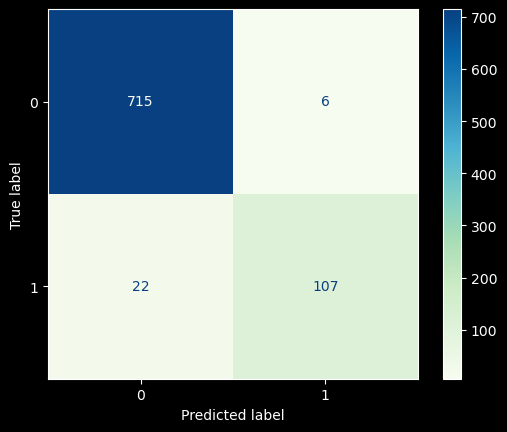

In [51]:
ConfusionMatrixDisplay.from_estimator(xgb_model_1, X_test, y_test, cmap='GnBu')
plt.show()

In [52]:
print('Precision: %.3f' % precision_score(y_test, y_pred1))
print('Recall: %.3f' % recall_score(y_test, y_pred1))
print('F1: %.3f' % f1_score(y_test, y_pred1))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred1))

Precision: 0.947
Recall: 0.829
F1: 0.884
Accuracy: 0.967


## xgb model 2, Optuna

In [53]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [54]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [55]:
study = optuna.create_study(direction='maximize',study_name='XGBoost_optuna')

In [56]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [57]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.9705882352941176
  Params: 
    max_depth: 3
    learning_rate: 0.07362402401613002
    n_estimators: 325
    min_child_weight: 4
    gamma: 0.08456873577805078
    subsample: 0.7802374868908096
    colsample_bytree: 0.5780108697380104
    reg_alpha: 0.5834545721477952
    reg_lambda: 0.8248256941316385


In [58]:
trial.params

{'max_depth': 3,
 'learning_rate': 0.07362402401613002,
 'n_estimators': 325,
 'min_child_weight': 4,
 'gamma': 0.08456873577805078,
 'subsample': 0.7802374868908096,
 'colsample_bytree': 0.5780108697380104,
 'reg_alpha': 0.5834545721477952,
 'reg_lambda': 0.8248256941316385}

/tmp/ipykernel_14436/2122237422.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


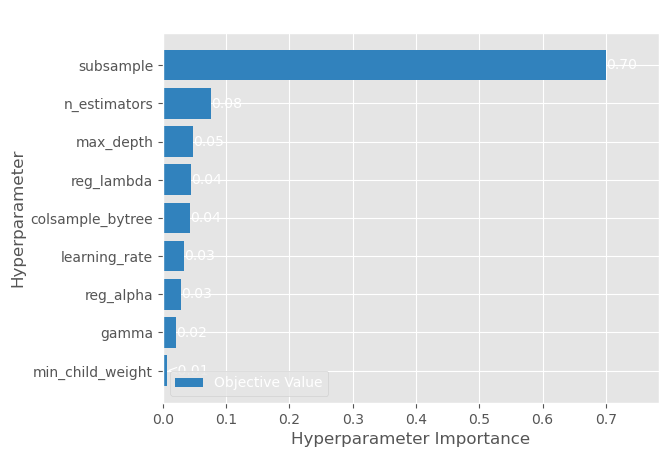

In [59]:
plot_param_importances(study);

In [60]:
params = trial.params

In [61]:
trial.params

{'max_depth': 3,
 'learning_rate': 0.07362402401613002,
 'n_estimators': 325,
 'min_child_weight': 4,
 'gamma': 0.08456873577805078,
 'subsample': 0.7802374868908096,
 'colsample_bytree': 0.5780108697380104,
 'reg_alpha': 0.5834545721477952,
 'reg_lambda': 0.8248256941316385}

In [62]:
xgb_model_2 = XGBClassifier(**params)

In [63]:
xgb_model_2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5780108697380104, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.08456873577805078,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07362402401613002,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=325, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [64]:
y_pred2 = xgb_model_2.predict(X_test)

In [65]:
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy after tuning: %.2f%%" % (accuracy * 100.0))

Accuracy after tuning: 97.06%


In [66]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       721
           1       0.97      0.83      0.90       129

    accuracy                           0.97       850
   macro avg       0.97      0.91      0.94       850
weighted avg       0.97      0.97      0.97       850



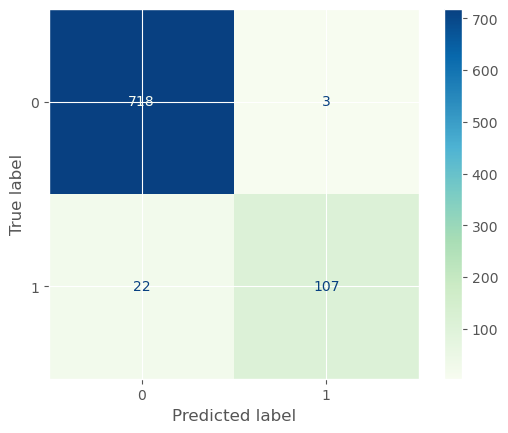

In [67]:
ConfusionMatrixDisplay.from_estimator(xgb_model_2, X_test, y_test, cmap='GnBu')
plt.show()

In [68]:
print('Precision: %.3f' % precision_score(y_test, y_pred2))
print('Recall: %.3f' % recall_score(y_test, y_pred2))
print('F1: %.3f' % f1_score(y_test, y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred2))

Precision: 0.973
Recall: 0.829
F1: 0.895
Accuracy: 0.971


## xgb model 3

In [69]:
parameters = {
    'max_depth': 6,
    'learning_rate': 0.03,
    'n_estimators': 3000,
    'early_stopping_rounds': 30,
    'min_child_weight':3,
    'gamma': 0.6,
    'subsample':0.9,
    'colsample_bytree':0.75,
    'reg_alpha':0.45,
    'reg_lambda':0.87,
    'random_state':42
}

In [70]:
xgb_model_3 = XGBClassifier(**parameters)

In [71]:
xgb_model_3.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-logloss:0.41675
[1]	validation_0-logloss:0.40370
[2]	validation_0-logloss:0.39204
[3]	validation_0-logloss:0.38217
[4]	validation_0-logloss:0.37232
[5]	validation_0-logloss:0.36304
[6]	validation_0-logloss:0.35535
[7]	validation_0-logloss:0.34910
[8]	validation_0-logloss:0.34530
[9]	validation_0-logloss:0.34067
[10]	validation_0-logloss:0.33508
[11]	validation_0-logloss:0.32804
[12]	validation_0-logloss:0.32324
[13]	validation_0-logloss:0.31827
[14]	validation_0-logloss:0.31360
[15]	validation_0-logloss:0.30947
[16]	validation_0-logloss:0.30317
[17]	validation_0-logloss:0.30106
[18]	validation_0-logloss:0.29728
[19]	validation_0-logloss:0.29203
[20]	validation_0-logloss:0.28629
[21]	validation_0-logloss:0.28182
[22]	validation_0-logloss:0.27756
[23]	validation_0-logloss:0.27510
[24]	validation_0-logloss:0.27132
[25]	validation_0-logloss:0.26768
[26]	validation_0-logloss:0.26491
[27]	validation_0-logloss:0.26164
[28]	validation_0-logloss:0.25984
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [72]:
y_pred3 = xgb_model_3.predict(X_test)

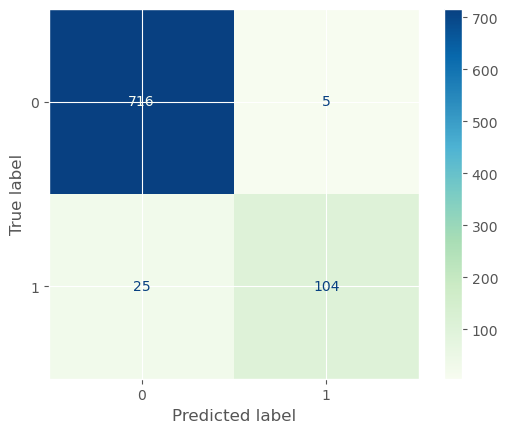

In [73]:
ConfusionMatrixDisplay.from_estimator(xgb_model_3, X_test, y_test, cmap='GnBu')
plt.show()

In [74]:
print('Precision: %.3f' % precision_score(y_test, y_pred3))
print('Recall: %.3f' % recall_score(y_test, y_pred3))
print('F1: %.3f' % f1_score(y_test, y_pred3))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred3))

Precision: 0.954
Recall: 0.806
F1: 0.874
Accuracy: 0.965


## xgb model 4

In [75]:
parameters = {
    'max_depth': 9,
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'early_stopping_rounds': 30,
    'min_child_weight':1,
    'gamma': 0.75,
    'subsample':0.82,
    'colsample_bytree':0.84,
    'reg_alpha':0.52,
    'reg_lambda':0.44,
    'random_state':42
}

In [76]:
xgb_model_4 = XGBClassifier(**parameters)

In [77]:
xgb_model_4.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-logloss:0.42558
[1]	validation_0-logloss:0.42043
[2]	validation_0-logloss:0.41568
[3]	validation_0-logloss:0.41090
[4]	validation_0-logloss:0.40664
[5]	validation_0-logloss:0.40223
[6]	validation_0-logloss:0.39791
[7]	validation_0-logloss:0.39478
[8]	validation_0-logloss:0.39161
[9]	validation_0-logloss:0.38864
[10]	validation_0-logloss:0.38573
[11]	validation_0-logloss:0.38181
[12]	validation_0-logloss:0.37898
[13]	validation_0-logloss:0.37627
[14]	validation_0-logloss:0.37368
[15]	validation_0-logloss:0.37089
[16]	validation_0-logloss:0.36747
[17]	validation_0-logloss:0.36493
[18]	validation_0-logloss:0.36244
[19]	validation_0-logloss:0.35933
[20]	validation_0-logloss:0.35625
[21]	validation_0-logloss:0.35310
[22]	validation_0-logloss:0.35018
[23]	validation_0-logloss:0.34844
[24]	validation_0-logloss:0.34580
[25]	validation_0-logloss:0.34275
[26]	validation_0-logloss:0.34094
[27]	validation_0-logloss:0.33816
[28]	validation_0-logloss:0.33616
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.84, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.75, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [78]:
y_pred4 = xgb_model_4.predict(X_test)

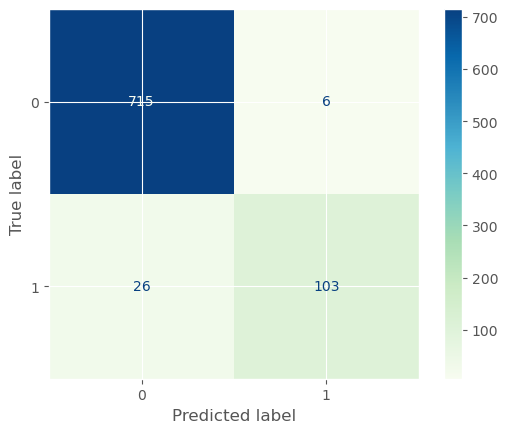

In [79]:
ConfusionMatrixDisplay.from_estimator(xgb_model_4, X_test, y_test, cmap='GnBu')
plt.show()

In [80]:
print('Precision: %.3f' % precision_score(y_test, y_pred4))
print('Recall: %.3f' % recall_score(y_test, y_pred4))
print('F1: %.3f' % f1_score(y_test, y_pred4))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred4))

Precision: 0.945
Recall: 0.798
F1: 0.866
Accuracy: 0.962


## xgb model 5 

In [81]:
parameters = {
    'max_depth': 4,
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'early_stopping_rounds': 30,
    'min_child_weight':2,
    'gamma': 0.53,
    'subsample':0.92,
    'colsample_bytree':0.76,
    'reg_alpha':0.58,
    'reg_lambda':0.45,
    'random_state':42
}

In [82]:
xgb_model_5 = XGBClassifier(**parameters)

In [83]:
xgb_model_5.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-logloss:0.42713
[1]	validation_0-logloss:0.42347
[2]	validation_0-logloss:0.42000
[3]	validation_0-logloss:0.41674
[4]	validation_0-logloss:0.41350
[5]	validation_0-logloss:0.41020
[6]	validation_0-logloss:0.40696
[7]	validation_0-logloss:0.40419
[8]	validation_0-logloss:0.40242
[9]	validation_0-logloss:0.39990
[10]	validation_0-logloss:0.39732
[11]	validation_0-logloss:0.39466
[12]	validation_0-logloss:0.39219
[13]	validation_0-logloss:0.38959
[14]	validation_0-logloss:0.38723
[15]	validation_0-logloss:0.38491
[16]	validation_0-logloss:0.38210
[17]	validation_0-logloss:0.38072
[18]	validation_0-logloss:0.37847
[19]	validation_0-logloss:0.37598
[20]	validation_0-logloss:0.37316
[21]	validation_0-logloss:0.37065
[22]	validation_0-logloss:0.36805
[23]	validation_0-logloss:0.36648
[24]	validation_0-logloss:0.36387
[25]	validation_0-logloss:0.36142
[26]	validation_0-logloss:0.35959
[27]	validation_0-logloss:0.35716
[28]	validation_0-logloss:0.35577
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.76, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.53, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [84]:
y_pred5 = xgb_model_5.predict(X_test)

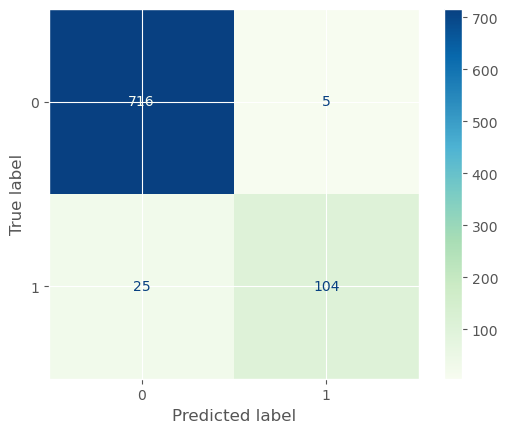

In [85]:
ConfusionMatrixDisplay.from_estimator(xgb_model_5, X_test, y_test, cmap='GnBu')
plt.show()

In [86]:
print('Precision: %.3f' % precision_score(y_test, y_pred5))
print('Recall: %.3f' % recall_score(y_test, y_pred5))
print('F1: %.3f' % f1_score(y_test, y_pred5))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred5))

Precision: 0.954
Recall: 0.806
F1: 0.874
Accuracy: 0.965


# CatBoost: 

## ctb model 1 default param

In [87]:
params = {'verbose':100,
          'random_seed':42,
         }

In [88]:
cbt_model_1 = CatBoostClassifier(**params)

In [89]:
cbt_model_1.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

Learning rate set to 0.042873
0:	learn: 0.6507171	test: 0.6532103	best: 0.6532103 (0)	total: 51.3ms	remaining: 51.3s
100:	learn: 0.1315175	test: 0.1583459	best: 0.1583459 (100)	total: 396ms	remaining: 3.53s
200:	learn: 0.1038434	test: 0.1463752	best: 0.1463268 (198)	total: 742ms	remaining: 2.95s
300:	learn: 0.0878653	test: 0.1456564	best: 0.1455602 (299)	total: 1.19s	remaining: 2.77s
400:	learn: 0.0738072	test: 0.1429454	best: 0.1429454 (400)	total: 1.63s	remaining: 2.43s
500:	learn: 0.0625940	test: 0.1415300	best: 0.1414006 (483)	total: 2.05s	remaining: 2.04s
600:	learn: 0.0535588	test: 0.1415509	best: 0.1411300 (536)	total: 2.42s	remaining: 1.6s
700:	learn: 0.0460258	test: 0.1412712	best: 0.1407948 (646)	total: 2.81s	remaining: 1.2s
800:	learn: 0.0402318	test: 0.1414818	best: 0.1407948 (646)	total: 3.16s	remaining: 786ms
900:	learn: 0.0346772	test: 0.1426623	best: 0.1407948 (646)	total: 3.48s	remaining: 382ms
999:	learn: 0.0304240	test: 0.1437032	best: 0.1407948 (646)	total: 3.81s	re

In [90]:
y_pred_cbt_1 = cbt_model_1.predict(X_test)

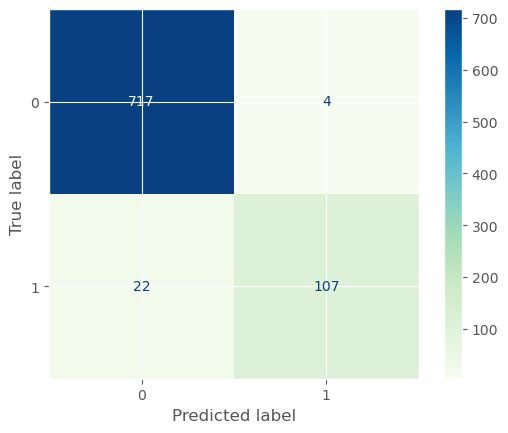

In [91]:
ConfusionMatrixDisplay.from_estimator(cbt_model_1, X_test, y_test, cmap='GnBu')
plt.show()

In [92]:
print('Precision: %.3f' % precision_score(y_test, y_pred_cbt_1))
print('Recall: %.3f' % recall_score(y_test, y_pred_cbt_1))
print('F1: %.3f' % f1_score(y_test, y_pred_cbt_1))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_cbt_1))

Precision: 0.964
Recall: 0.829
F1: 0.892
Accuracy: 0.969


## ctb model 2

In [93]:
params = {
    'iterations':5000,
    'verbose':300,
    'od_type' : "Iter",
    'od_wait' : 500,
    'learning_rate':0.01,
    'random_seed':42
}

In [94]:
cbt_model_2 = CatBoostClassifier(**params)

In [95]:
cbt_model_2.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

0:	learn: 0.6829766	test: 0.6835775	best: 0.6835775 (0)	total: 4.63ms	remaining: 23.2s
300:	learn: 0.1513176	test: 0.1748757	best: 0.1748757 (300)	total: 916ms	remaining: 14.3s
600:	learn: 0.1180033	test: 0.1529078	best: 0.1529078 (600)	total: 1.89s	remaining: 13.8s
900:	learn: 0.1016445	test: 0.1478518	best: 0.1478517 (891)	total: 2.75s	remaining: 12.5s
1200:	learn: 0.0899070	test: 0.1457138	best: 0.1456912 (1196)	total: 3.6s	remaining: 11.4s
1500:	learn: 0.0796552	test: 0.1442739	best: 0.1442739 (1500)	total: 4.49s	remaining: 10.5s
1800:	learn: 0.0708889	test: 0.1431610	best: 0.1431600 (1799)	total: 5.32s	remaining: 9.46s
2100:	learn: 0.0632303	test: 0.1426702	best: 0.1426435 (2084)	total: 6.17s	remaining: 8.51s
2400:	learn: 0.0566988	test: 0.1423528	best: 0.1422772 (2272)	total: 7.04s	remaining: 7.62s
2700:	learn: 0.0513991	test: 0.1422398	best: 0.1419955 (2517)	total: 7.86s	remaining: 6.69s
3000:	learn: 0.0460887	test: 0.1420990	best: 0.1419955 (2517)	total: 8.72s	remaining: 5.81s


In [96]:
y_pred_cbt_2 = cbt_model_2.predict(X_test)

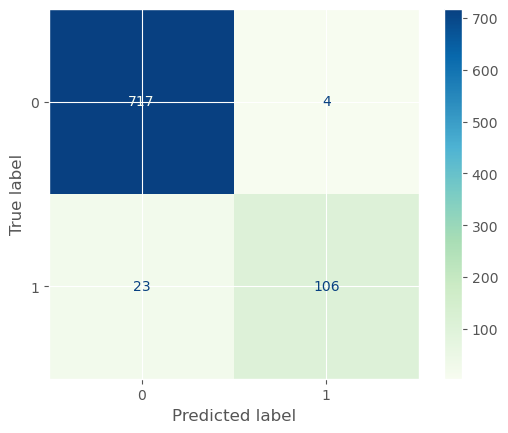

In [97]:
ConfusionMatrixDisplay.from_estimator(cbt_model_2, X_test, y_test, cmap='GnBu')
plt.show()

In [98]:
print('Precision: %.3f' % precision_score(y_test, y_pred_cbt_2))
print('Recall: %.3f' % recall_score(y_test, y_pred_cbt_2))
print('F1: %.3f' % f1_score(y_test, y_pred_cbt_2))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_cbt_2))

Precision: 0.964
Recall: 0.822
F1: 0.887
Accuracy: 0.968


# Summary: 

In [99]:
result = { 'metrics':['Precision','Recall','F1','Accuracy'],
          'xgb_model_1':
              [0.936,
               0.798,
               0.862,
               0.961],
          'xgb_model_2':
              [0.954,
               0.806,
               0.874,
               0.965],
           'xgb_model_3':
              [0.954,
               0.806,
               0.874,
               0.965],         
           'xgb_model_4':
              [0.954,
               0.806,
               0.874,
               0.965],
           'xgb_model_5':
              [0.954,
               0.806,
               0.874,
               0.965],
           'cbt_model_1':
              [0.964,
               0.829,
               0.892,
               0.969],
           'cbt_model_2':
               [0.964,
                0.822,
                0.887,
                0.968]
}

In [100]:
result_df = pd.DataFrame.from_dict(result)
result_df.T

,0,1,2,3
metrics,Precision,Recall,F1,Accuracy
xgb_model_1,0.936,0.798,0.862,0.961
xgb_model_2,0.954,0.806,0.874,0.965
xgb_model_3,0.954,0.806,0.874,0.965
xgb_model_4,0.954,0.806,0.874,0.965
xgb_model_5,0.954,0.806,0.874,0.965
cbt_model_1,0.964,0.829,0.892,0.969
cbt_model_2,0.964,0.822,0.887,0.968
